In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import nltk

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
import pickle


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1.Loading data

In [2]:
data  = pd.read_csv('preprocessed_data.csv')
data.head(2)

school_state teacher_prefix project_grade_category  \
0           ca            mrs          grades_prek_2   
1           ut             ms             grades_3_5   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   
1                                             4                    1   

  clean_categories                 clean_subcategories  \
0     math_science  appliedsciences health_lifescience   
1     specialneeds                        specialneeds   

                                               essay   price  
0  i fortunate enough use fairy tale stem kits cl...  725.05  
1  imagine 8 9 years old you third grade classroo...  213.03

In [3]:
X=data.drop(['project_is_approved'],axis=1)
Y=data['project_is_approved'].values

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33,stratify=Y,random_state=42)

X_train.shape,'train-x',Y_train.shape,'train-y',X_test.shape,'test-x',Y_test.shape,'test-y'


((73196, 8),
 'train-x',
 (73196,),
 'train-y',
 (36052, 8),
 'test-x',
 (36052,),
 'test-y')

# 2.Vectorization

### 2.1.Bag of words

In [4]:
train_essays = X_train['essay'].values
test_essays = X_test['essay'].values
vectorizer = CountVectorizer(min_df=10)      #taking words which has been appeared in at least 10 doc (min_df=10)
vectorizer.fit(train_essays)
train_text_bow = vectorizer.transform(train_essays)
test_text_bow = vectorizer.transform(test_essays)
words_dict1 = vectorizer.vocabulary_
print("Shape of matrix after one hot encodig train and test ",train_text_bow.shape,test_text_bow.shape)

Shape of matrix after one hot encodig train and test  (73196, 14266) (36052, 14266)


### 2.2.TFIDF Vectorizer

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(min_df=10)     #taking words which has been appeared in at least 10 doc (min_df=10)
vectorizer_tfidf=vectorizer_tfidf.fit(train_essays)
train_text_tfidf = vectorizer_tfidf.transform(train_essays)
test_text_tfidf = vectorizer_tfidf.transform(test_essays)
words_dict = vectorizer_tfidf.vocabulary_
print("Shape of matrix after one hot encodig train and test",train_text_tfidf.shape,test_text_tfidf.shape)

Shape of matrix after one hot encodig train and test (73196, 14266) (36052, 14266)


### 2.3.Encoding numerical, categorical features

In [6]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
vectorizer_1 = CountVectorizer(binary=True)
vectorizer_1.fit(X_train['school_state'].values)
X_train_state = vectorizer_1.transform(X_train['school_state'].values)
X_test_state = vectorizer_1.transform(X_test['school_state'].values)
w1=vectorizer_1.get_feature_names()

vectorizer_1.fit(X_train['teacher_prefix'].values)
X_train_teacher = vectorizer_1.transform(X_train['teacher_prefix'].values)
X_test_teacher = vectorizer_1.transform(X_test['teacher_prefix'].values)
w2=vectorizer_1.get_feature_names()

vectorizer_1.fit(X_train['project_grade_category'].values)
X_train_grade = vectorizer_1.transform(X_train['project_grade_category'].values)
X_test_grade = vectorizer_1.transform(X_test['project_grade_category'].values)
w3=vectorizer_1.get_feature_names()

vectorizer_1.fit(X_train['clean_categories'].values)
X_train_categories = vectorizer_1.transform(X_train['clean_categories'].values)
X_test_categories = vectorizer_1.transform(X_test['clean_categories'].values)
w4=vectorizer_1.get_feature_names()

vectorizer_1.fit(X_train['clean_subcategories'].values)
X_train_subcate = vectorizer_1.transform(X_train['clean_subcategories'].values)
X_test_subcate = vectorizer_1.transform(X_test['clean_subcategories'].values)
w5=vectorizer_1.get_feature_names()

# Apply Normalization on the numerical features using Normalizer().

normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(-1,1))
X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_train_num_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_num_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

### 2.4.avg W2V

In [7]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [8]:
# average Word2Vec
# compute average word2vec for each review.

def avg_w2v_vectors(data):
    avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(data): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return avg_w2v_vectors

train_w2v=avg_w2v_vectors(train_essays)
test_w2v=avg_w2v_vectors(test_essays)

print(len(train_w2v))
print(len(train_w2v[0]))
print(len(test_w2v))
print(len(test_w2v[0]))

100%|██████████████████████████████████████████████████████████████████████████| 36052/36052 [00:09<00:00, 3938.50it/s]

73196
300
36052
300


### 2.4.Sentiment scores

In [9]:
sid = SentimentIntensityAnalyzer()

def analyzer(data):
    neg=[]
    neu=[]
    pos=[]
    compound=[]
    for i in tqdm(data):
        s=sid.polarity_scores(i)
        neg.append(s['neg'])
        neu.append(s['neu'])
        pos.append(s['pos'])
        compound.append(s['compound'])
    
    return neg,neu,pos,compound 
    
neg,neu,pos,compound=analyzer(train_essays)
neg_test,neu_test,pos_test,compound_test=analyzer(test_essays)    

100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [01:01<00:00, 588.64it/s]


In [10]:
neg=np.reshape(neg,(-1,1))
neu=np.reshape(neu,(-1,1))
pos=np.reshape(pos,(-1,1))
compound=np.reshape(compound,(-1,1))


neg_test=np.reshape(neg_test,(-1,1))
neu_test=np.reshape(neu_test,(-1,1))
pos_test=np.reshape(pos_test,(-1,1))
compound_test=np.reshape(compound_test,(-1,1))


## 3. data set 1

In [11]:
from scipy.sparse import hstack
X_tr = hstack((train_text_tfidf , X_train_state , X_train_teacher , X_train_grade , X_train_categories , X_train_subcate , X_train_price_norm , X_train_num_norm , neg , neu , pos , compound)).tocsr()
X_te = hstack((test_text_tfidf , X_test_state , X_test_teacher , X_test_grade , X_test_categories , X_test_subcate , X_test_price_norm , X_test_num_norm , neg_test , neu_test , pos_test , compound_test)).tocsr()

print(X_tr.get_shape(),"shape of training data set")
print(X_te.get_shape(),"shape of testing data set")



(73196, 14371) shape of training data set
(36052, 14371) shape of testing data set


## 4.Finding the best hyperparameter by gridsearch

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
# https://stackoverflow.com/questions/37689942/grid-search-finding-parameters-for-auc

DT = DecisionTreeClassifier(random_state=0)

parameters={'max_depth':[1, 3, 10, 30],
            'min_samples_split':[5, 10, 100, 500]}

clf = GridSearchCV(DT, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)

%time clf.fit(X_tr,Y_train)

Wall time: 5min 21s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [13]:
from sklearn.metrics import roc_auc_score
print(clf.best_params_)
print(clf.best_score_)


Y_pred=clf.predict_proba(X_te)[:,1]
roc_auc_score(Y_test,Y_pred)


{'max_depth': 10, 'min_samples_split': 500}
0.6213432487888448


0.6326290885912592

## 5.Performance metrics
### 5.1 plotting 3D graph

In [14]:
#print(clf.cv_results_)
x1=clf.cv_results_['param_min_samples_split'].data
y1=clf.cv_results_['param_max_depth'].data
z1=clf.cv_results_['mean_train_score'] #train data score 
z2=clf.cv_results_['mean_test_score']  #cv data score



In [15]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np
import matplotlib.pyplot as plt


# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x1,y=y1,z=z2, name = 'Cross validation')
data = [trace1,trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')



### 5.2 Finding the AUC

In [16]:
from sklearn.metrics import confusion_matrix

DT_best = DecisionTreeClassifier(random_state=0,max_depth= 10,min_samples_split=500)
DT_best.fit(X_tr,Y_train)



DecisionTreeClassifier(max_depth=10, min_samples_split=500, random_state=0)

test=  0.6326290885912592
train=  0.6581864503489774


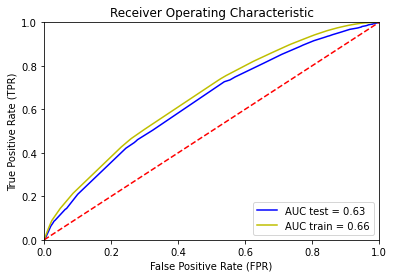

In [17]:

y_pred=DT_best.predict_proba(X_te)[:,1]    # predict the probabitity of class 1 = (approved)
print("test= ",metrics.roc_auc_score(Y_test, y_pred))
fpr, tpr, threshold = metrics.roc_curve(Y_test, y_pred)
roc_auc_test = metrics.auc(fpr, tpr)

y_pred_class_train = DT_best.predict_proba(X_tr)[:,1]   # predict the probabitity of class 1 = (approved)
print("train= ",metrics.roc_auc_score(Y_train, y_pred_class_train))
fpr_1, tpr_1, threshold_1 = metrics.roc_curve(Y_train, y_pred_class_train)
roc_auc_train = metrics.auc(fpr_1, tpr_1)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC test = %0.2f' % roc_auc_test)
plt.plot(fpr_1, tpr_1, 'y', label = 'AUC train = %0.2f' % roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()

### 5.3 Confustion matrix
#### 5.31. Training data set

[[  611 10472]
 [  274 61839]]


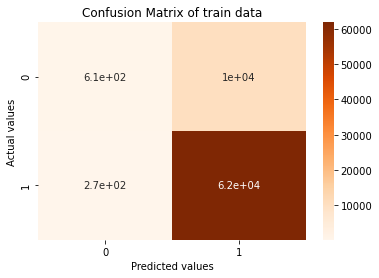

In [18]:
import seaborn as sns

y_pred_bi=DT_best.predict(X_tr)
cf_matrix=confusion_matrix(Y_train,y_pred_bi)

ax= plt.subplot();
sns.heatmap(cf_matrix, annot=True,cmap='Oranges',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix of train data');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);
print(cf_matrix)




#### 5.32 Test data set

[[  143  5316]
 [  296 30297]]


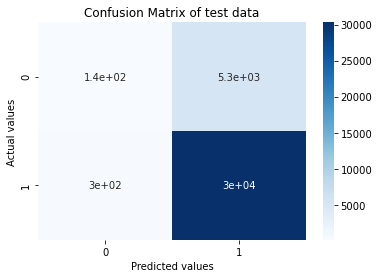

In [19]:
y_pred_bi=DT_best.predict(X_te)
cf_matrix=confusion_matrix(Y_test,y_pred_bi)

ax= plt.subplot();
sns.heatmap(cf_matrix, annot=True,cmap='Blues',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix of test data');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);
print(cf_matrix)

### 3.4 word cloud

In [20]:
def fp_index(Y_test,y_pred_bi):  # False positive function returns index of the point with false positive
    index=[]
    for i in range(len(Y_test)):
        if ((Y_test[i] == 0)&(y_pred_bi[i] == 1)):
            index.append(i)
    return index
                
index=fp_index(Y_test,y_pred_bi) #test data
#print(index)

def pts(index,data):           # returns the pts taking index and data set
    pts=[]
    for i in index:
        pts.append(data[i]) 
    return pts

false_positive_pts=pts(index,test_essays)  #test essays



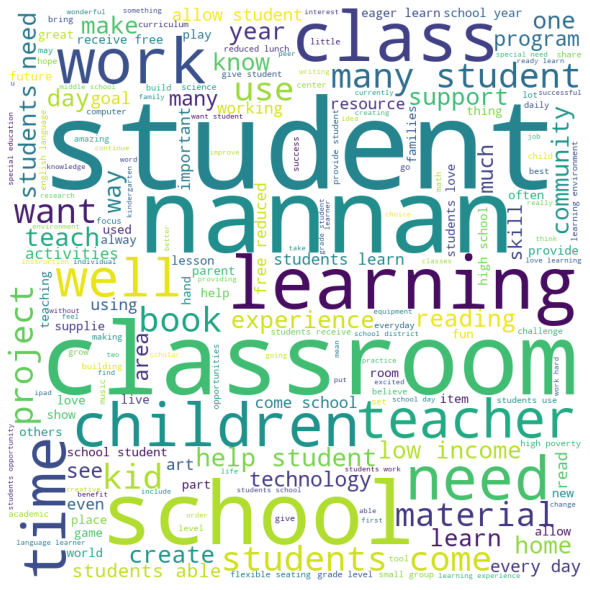

In [95]:
from wordcloud import WordCloud, STOPWORDS

# Python program to generate WordCloud


comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in false_positive_pts:
    
    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


### 3.5 Box-plot of price of false positive points

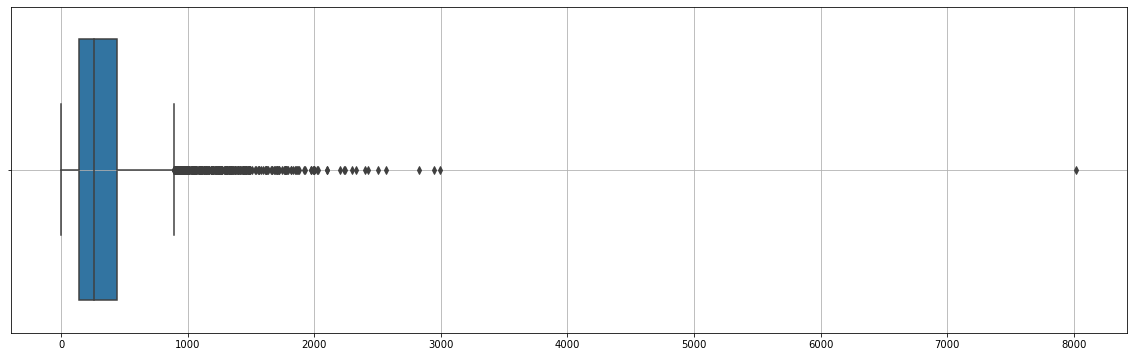

In [21]:
plt.figure(figsize=(20,6))
false_positive_price=pts(index,X_test["price"].values)
sns.boxplot(x=false_positive_price)
plt.grid()


### 3.6 PDF of teacher's perviously posted project 

Text(0, 0.5, 'Probability')

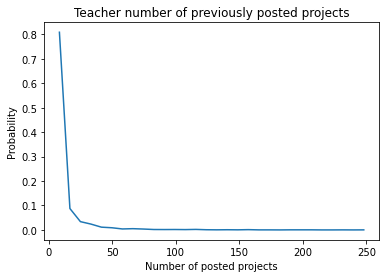

In [22]:
# refered assigment 2 for this code
false_positive_pre_post_teach=pts(index,X_test["teacher_number_of_previously_posted_projects"].values)
counts, bin_edges = np.histogram(false_positive_pre_post_teach, bins=30, 
                                 density = True)
pdf = counts/(sum(counts))
plt.plot(bin_edges[1:],pdf);
plt.title("Teacher number of previously posted projects")
plt.xlabel("Number of posted projects")
plt.ylabel("Probability")

# Data set 2

In [23]:
from scipy.sparse import hstack
X_tr_2 = hstack((train_w2v , X_train_state , X_train_teacher , X_train_grade , X_train_categories , X_train_subcate , X_train_price_norm , X_train_num_norm , neg , neu , pos , compound)).tocsr()
X_te_2 = hstack((test_w2v , X_test_state , X_test_teacher , X_test_grade , X_test_categories , X_test_subcate , X_test_price_norm , X_test_num_norm , neg_test , neu_test , pos_test , compound_test)).tocsr()

print(X_tr_2.get_shape(),"shape of training data set")
print(X_te_2.get_shape(),"shape of testing data set")



(73196, 405) shape of training data set
(36052, 405) shape of testing data set


### 1.Finding the best hyperparameter by gridsearch data set 2

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
# https://stackoverflow.com/questions/37689942/grid-search-finding-parameters-for-auc

DT_2 = DecisionTreeClassifier(random_state=0)

parameters={'max_depth':[1, 3, 10, 30],
            'min_samples_split':[5, 10, 100, 500]}

clf_2 = GridSearchCV(DT_2, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)

%time clf_2.fit(X_tr_2,Y_train)

Wall time: 15min 15s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [28]:
print(clf.best_params_)
print(clf.best_score_)


Y_pred=clf_2.predict_proba(X_te_2)[:,1]
roc_auc_score(Y_test,Y_pred)

{'max_depth': 10, 'min_samples_split': 500}
0.6033990293971241
[0.69552239 0.91318865 0.90697674 ... 0.86819484 0.9151671  0.93388241]


0.6111562342523618

### 2. plotting 3D graph

In [29]:
#print(clf.cv_results_)
x1=clf_2.cv_results_['param_min_samples_split'].data
y1=clf_2.cv_results_['param_max_depth'].data
z1=clf_2.cv_results_['mean_train_score'] #train data score 
z2=clf_2.cv_results_['mean_test_score']  #cv data score

In [30]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np
import matplotlib.pyplot as plt


# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x1,y=y1,z=z2, name = 'Cross validation')
data = [trace1,trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

### 2.1 Finding the AUC

test=  0.6111562342523618
train=  0.6862585189207715


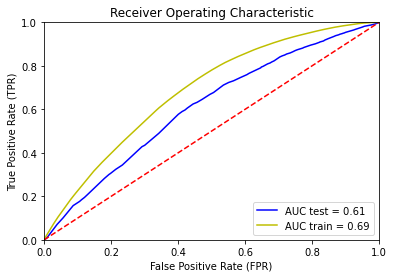

In [32]:
DT_best_2 = DecisionTreeClassifier(random_state=0,max_depth= 10,min_samples_split=500)
DT_best_2.fit(X_tr_2,Y_train)

y_pred=DT_best_2.predict_proba(X_te_2)[:,1]    # predict the probabitity of class 1 = (approved)
print("test= ",metrics.roc_auc_score(Y_test, y_pred))
fpr, tpr, threshold = metrics.roc_curve(Y_test, y_pred)
roc_auc_test = metrics.auc(fpr, tpr)

y_pred_class_train = DT_best_2.predict_proba(X_tr_2)[:,1]   # predict the probabitity of class 1 = (approved)
print("train= ",metrics.roc_auc_score(Y_train, y_pred_class_train))
fpr_1, tpr_1, threshold_1 = metrics.roc_curve(Y_train, y_pred_class_train)
roc_auc_train = metrics.auc(fpr_1, tpr_1)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC test = %0.2f' % roc_auc_test)
plt.plot(fpr_1, tpr_1, 'y', label = 'AUC train = %0.2f' % roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()

### 2.2 Confustion matrix
#### Train data set

[[  624 10459]
 [  302 61811]]


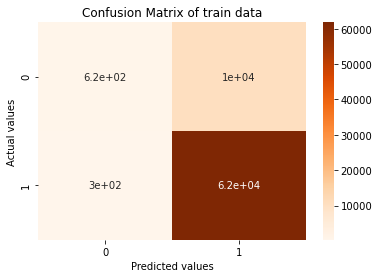

In [34]:
y_pred_bi=DT_best_2.predict(X_tr_2)
cf_matrix=confusion_matrix(Y_train,y_pred_bi)

ax= plt.subplot();
sns.heatmap(cf_matrix, annot=True,cmap='Oranges',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix of train data');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);
print(cf_matrix)



#### Test data set

[[  125  5334]
 [  364 30229]]


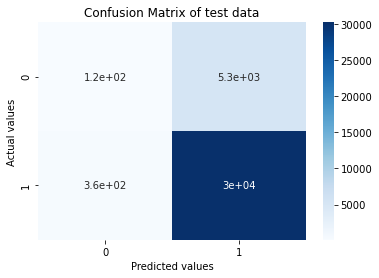

In [35]:
y_pred_bi=DT_best_2.predict(X_te_2)
cf_matrix=confusion_matrix(Y_test,y_pred_bi)

ax= plt.subplot();
sns.heatmap(cf_matrix, annot=True,cmap='Blues',ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_ylim(2.0, 0)
ax.set_title('Confusion Matrix of test data');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);
print(cf_matrix)

### 2.3 Word cloud

In [40]:
def fp_index(Y_test,y_pred_bi):  # False positive function returns index of the point with false positive
    index=[]
    for i in range(len(Y_test)):
        if ((Y_test[i] == 0)&(y_pred_bi[i] == 1)):
            index.append(i)
    return index
                
index=fp_index(Y_test,y_pred_bi) #test data
#print(index)

def pts(index,data):           # returns the pts taking index and data set
    pts=[]
    for i in index:
        pts.append(data[i]) 
    return pts

false_positive_pts=pts(index,test_essays)  #test essays
len(false_positive_pts)


5334

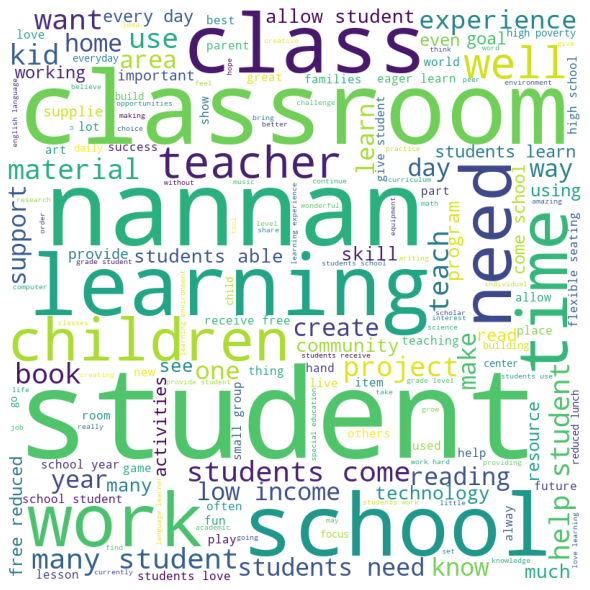

In [37]:
from wordcloud import WordCloud, STOPWORDS

# Python program to generate WordCloud


comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in false_positive_pts:
    
    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### 2.4 Boxplot

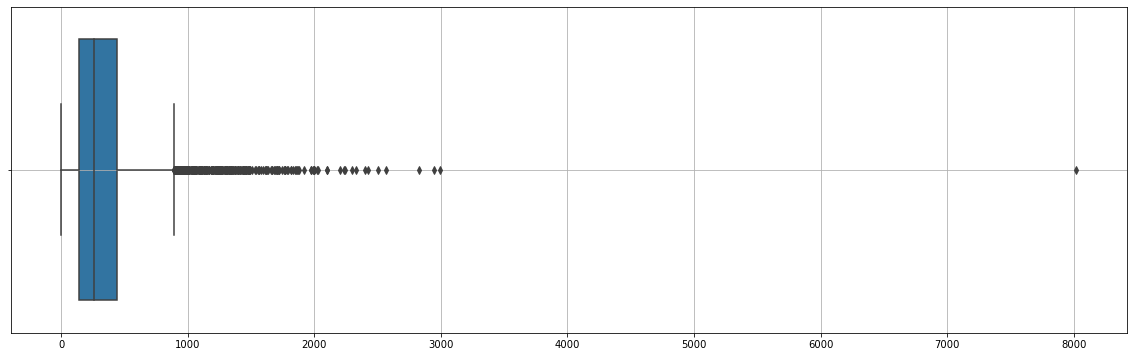

In [38]:
plt.figure(figsize=(20,6))
false_positive_price=pts(index,X_test["price"].values)
sns.boxplot(x=false_positive_price)
plt.grid()

### 2.5 PDF

Text(0, 0.5, 'Probability')

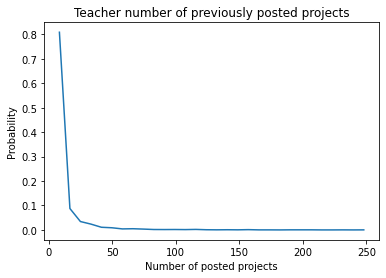

In [39]:
false_positive_pre_post_teach=pts(index,X_test["teacher_number_of_previously_posted_projects"].values)
counts, bin_edges = np.histogram(false_positive_pre_post_teach, bins=30, 
                                 density = True)
pdf = counts/(sum(counts))
plt.plot(bin_edges[1:],pdf);
plt.title("Teacher number of previously posted projects")
plt.xlabel("Number of posted projects")
plt.ylabel("Probability")